<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1">Goal</a></span></li><li><span><a href="#Baselines" data-toc-modified-id="Baselines-2">Baselines</a></span><ul class="toc-item"><li><span><a href="#Motivation" data-toc-modified-id="Motivation-2.1">Motivation</a></span></li></ul></li><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-3">Prepare data</a></span><ul class="toc-item"><li><span><a href="#Limit-to-a-smaller-area" data-toc-modified-id="Limit-to-a-smaller-area-3.1">Limit to a smaller area</a></span></li><li><span><a href="#Round-time" data-toc-modified-id="Round-time-3.2">Round time</a></span></li><li><span><a href="#Number-of-requests" data-toc-modified-id="Number-of-requests-3.3">Number of requests</a></span></li><li><span><a href="#Create-grid" data-toc-modified-id="Create-grid-3.4">Create grid</a></span><ul class="toc-item"><li><span><a href="#Area-size" data-toc-modified-id="Area-size-3.4.1">Area size</a></span></li><li><span><a href="#Cells" data-toc-modified-id="Cells-3.4.2">Cells</a></span></li></ul></li></ul></li><li><span><a href="#Total-demand" data-toc-modified-id="Total-demand-4">Total demand</a></span><ul class="toc-item"><li><span><a href="#Daily-demand" data-toc-modified-id="Daily-demand-4.1">Daily demand</a></span><ul class="toc-item"><li><span><a href="#Aggregation" data-toc-modified-id="Aggregation-4.1.1">Aggregation</a></span></li><li><span><a href="#Seasonal-plot" data-toc-modified-id="Seasonal-plot-4.1.2">Seasonal plot</a></span></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-4.1.3">Prediction</a></span><ul class="toc-item"><li><span><a href="#Features" data-toc-modified-id="Features-4.1.3.1">Features</a></span></li></ul></li><li><span><a href="#Time-series" data-toc-modified-id="Time-series-4.1.4">Time series</a></span></li></ul></li><li><span><a href="#Trend-and-seasonality" data-toc-modified-id="Trend-and-seasonality-4.2">Trend and seasonality</a></span></li><li><span><a href="#Autocorrelation" data-toc-modified-id="Autocorrelation-4.3">Autocorrelation</a></span></li><li><span><a href="#Seasonal-plot" data-toc-modified-id="Seasonal-plot-4.4">Seasonal plot</a></span></li></ul></li></ul></div>

# Goal

Predict demand in a particular area:

- for the next 15 minutes
- for the next 2 hours
- for the next day:
    - from 5am to 2pm
    - from 2pm to 6m
    - from 6pm to 11pm

# Baselines


## Motivation

Create a set of baselines for demand prediction using conventional methods:

* time series prediction
* per cell prediction using any type of regressor, e.g. gradient boosting regressor

# Prepare data

In [75]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [649]:
%%time 

raw_data = pd.read_feather('../data/data.feather')

print(f'Dataset shape: {raw_data.shape}\n')
raw_data.head(3)

Dataset shape: (65783796, 8)

CPU times: user 3.1 s, sys: 11.6 s, total: 14.7 s
Wall time: 38.6 s


,pickup_datetime,dropoff_datetime,passenger_count,distance,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat
0,2015-01-01 00:00:00,2015-01-01 00:00:00,3,2.510570,-74.001320,40.729057,-74.010208,40.719662
1,2015-01-01 00:00:00,2015-01-01 00:11:26,5,6.437360,-73.971436,40.760201,-73.921181,40.768269
2,2015-01-01 00:00:03,2015-01-01 00:10:50,1,2.542757,-73.987579,40.765270,-73.976921,40.776970


In [650]:
raw_data.drop(['dropoff_datetime', 'passenger_count', 'distance',
           'dropoff_lon', 'dropoff_lat'], axis=1, inplace=True)

raw_data.columns = ['datetime', 'lon', 'lat']

raw_data.head(3)

,datetime,lon,lat
0,2015-01-01 00:00:00,-74.001320,40.729057
1,2015-01-01 00:00:00,-73.971436,40.760201
2,2015-01-01 00:00:03,-73.987579,40.765270


In [630]:
raw_data.groupby(raw_data.datetime.dt.month_name()).datetime.count()

datetime
April       11149321
February    10684310
January     11003793
June        10476187
March       11344679
May         11125506
Name: datetime, dtype: int64

In [631]:
raw_data.lon.describe()

count    6.578380e+07
mean    -7.398129e+01
std      1.672455e-02
min     -7.402862e+01
25%     -7.399256e+01
50%     -7.398251e+01
75%     -7.397061e+01
max     -7.391499e+01
Name: lon, dtype: float64

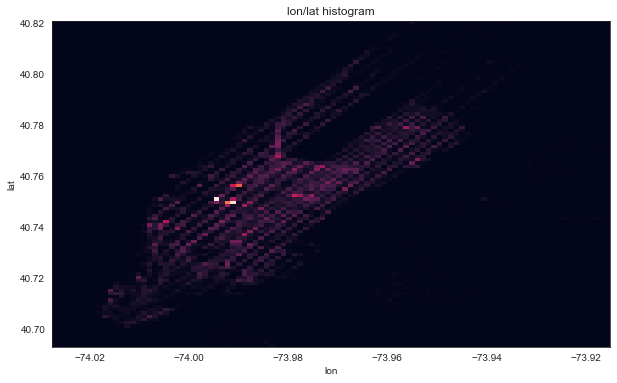

In [635]:
plt.figure(figsize=(10, 6))

sample = raw_data.sample(100000)

plt.hist2d(sample.lon, sample.lat, bins=100);
plt.title('lon/lat histogram');
plt.xlabel('lon');
plt.ylabel('lat');

## Limit to a smaller area

Use area selected manually using http://geojson.io/#map=15/40.7357/-73.9889

In [651]:
bbox = ((-73.996, -73.9817), (40.7308, 40.7416))

(min_lon, max_lon), (min_lat, max_lat) = bbox

idx = (raw_data.lat >= min_lat) & (raw_data.lat <= max_lat)
idx = idx & (raw_data.lon >= min_lon) & (raw_data.lon <= max_lon)

print(f'Dataset size: {raw_data.shape[0]}')
print(f'Sample size: {idx.sum()}')

data = raw_data[idx].reset_index(drop=True)

Dataset size: 65783796
Sample size: 4178083


Demand per day stats:

In [637]:
data.datetime.dt.date.value_counts().describe()

count      181.000000
mean     23083.331492
std       3587.589954
min       7721.000000
25%      21048.000000
50%      23231.000000
75%      24887.000000
max      34103.000000
Name: datetime, dtype: float64

## Round time

In [652]:
data.datetime = data.datetime.dt.round('15min')

data.sample(5)

,datetime,lon,lat
411375,2015-01-18 15:30:00,-73.991028,40.734093
978344,2015-02-11 19:15:00,-73.992378,40.737694
1389783,2015-02-27 23:45:00,-73.986122,40.730972
3131470,2015-05-13 01:30:00,-73.981979,40.736423
3488852,2015-05-29 22:45:00,-73.989830,40.741459


Create a grid and count the *number of requests per cell*

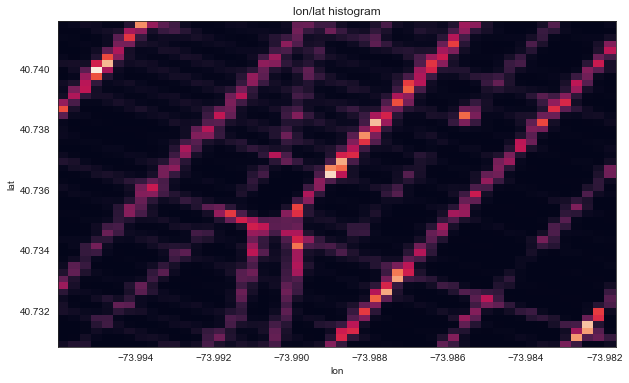

In [639]:
plt.figure(figsize=(10, 6))

plt.hist2d(data.lon, data.lat, bins=50);
plt.title('lon/lat histogram');
plt.xlabel('lon');
plt.ylabel('lat');

## Number of requests

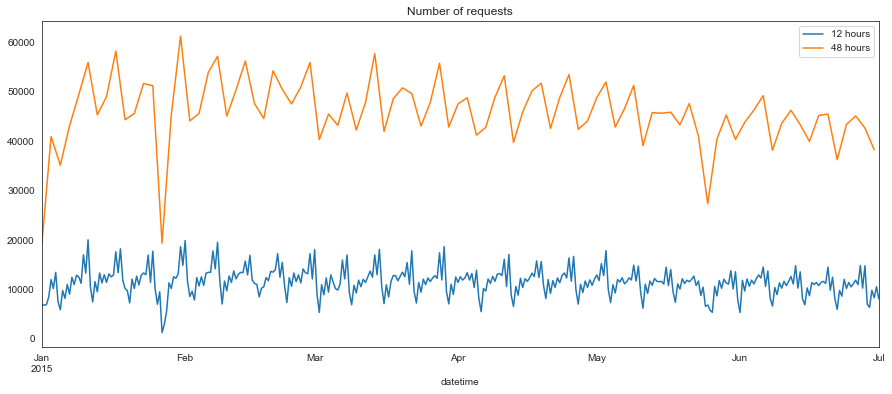

In [667]:
plt.figure(figsize=(15, 6))

plt.title('Number of requests')
data.groupby(
    data.datetime.dt.round('12h')).datetime.count().plot(label='12 hours')
data.groupby(
    data.datetime.dt.round('48h')).datetime.count().plot(label='48 hours')
plt.legend();

## Create grid

### Area size

In [654]:
import haversine

point1 = (bbox[1][0], bbox[0][0])
point2 = (bbox[1][0], bbox[0][1])
point3 = (bbox[1][1], bbox[0][0])

dx = haversine.haversine(point1, point2)
dy = haversine.haversine(point1, point3)

print(f'Area size is {dx:.2f} x {dy:.2f} km')

Area size is 1.20 x 1.20 km


### Cells

Create 50x50 meters cells

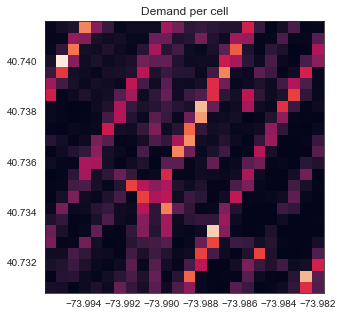

In [657]:
# cell_size x cell_size grid
cell_size = 24

plt.figure(figsize=(5, 5))

plt.title('Demand per cell')
plt.hist2d(data.lon, data.lat, bins=cell_size);

In [655]:
%%time

xcells = np.linspace(bbox[0][0], bbox[0][1], cell_size)
data['x_cell'] = np.digitize(data.lon, xcells)

ycells = np.linspace(bbox[1][0], bbox[1][1], cell_size)
data['y_cell'] = np.digitize(data.lat, ycells)

data['cell'] = data.apply(
    lambda item: '{}-{}'.format(item.x_cell, item.y_cell), axis=1)

data.head(5)

CPU times: user 2min 19s, sys: 3.09 s, total: 2min 23s
Wall time: 2min 29s


,datetime,lon,lat,x_cell,y_cell,cell
0,2015-01-01,-73.986000,40.740601,17,21,17-21
1,2015-01-01,-73.990891,40.738850,9,18,9-18
2,2015-01-01,-73.990509,40.735027,9,10,9-10
3,2015-01-01,-73.987442,40.733410,14,6,14-6
4,2015-01-01,-73.985779,40.731773,17,3,17-3


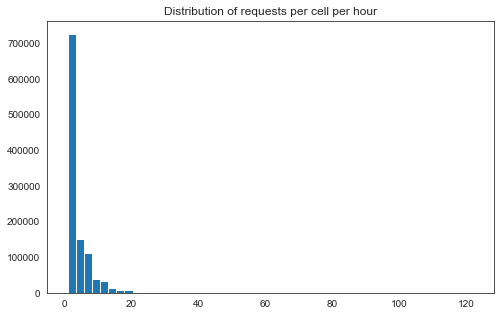

In [658]:
plt.figure(figsize=(8, 5))

plt.title('Distribution of requests per cell per hour')
plt.hist(data.groupby([data.datetime.dt.round('1h'), 'cell']).cell.count(),
         bins=50);

# Total demand

Demand for all cell at the same time

## Daily demand

### Aggregation

In [662]:
groups = data.groupby(data.datetime.dt.date)
demand_data = groups.datetime.count().to_frame(name='total')

demand_data.reset_index(inplace=True)

demand_data.datetime = pd.to_datetime(demand_data.datetime)
demand_data['month'] = demand_data.datetime.dt.month_name()
demand_data['day'] = demand_data.datetime.dt.day

demand_data.head(3)

,datetime,total,month,day
0,2015-01-01,18873,January,1
1,2015-01-02,17611,January,2
2,2015-01-03,23469,January,3


### Seasonal plot

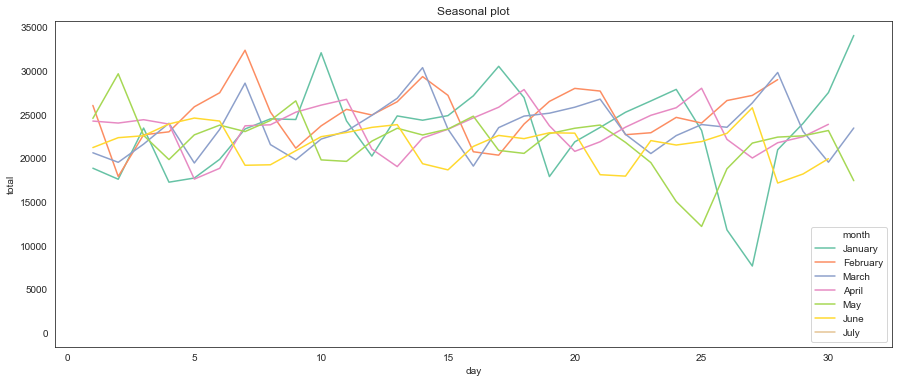

In [665]:
plt.figure(figsize=(15, 6))

plt.title('Seasonal plot')

palette = sns.color_palette('Set2', demand_data.month.nunique())

sns.lineplot(x='day',
             y='total',
             data=demand_data,
             estimator='mean',
             ci=95,
             hue='month',
             palette=palette);

### Prediction

#### Features

In [682]:
y = demand_data.total.values

X = demand_data.day.to_frame().reset_index(drop=True)
X['month'] = demand_data.datetime.dt.month
X['day_of_week'] = demand_data.datetime.dt.dayofweek
X['week'] = demand_data.datetime.dt.week
X['quarter'] = demand_data.datetime.dt.quarter

X.head(3)

,day,month,day_of_week,week,quarter
0,1,1,3,1,1
1,2,1,4,1,1
2,3,1,5,1,1


In [725]:
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

tscv = model_selection.TimeSeriesSplit(n_splits=5)

errors = []
for train_index, test_index in tscv.split(X):

    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = ensemble.GradientBoostingRegressor()
    model.fit(X_train, y_train)

    pred = model.predict(X_test)

    err = metrics.mean_squared_error(y_test, pred, squared=False)
    print(f'\nRMSE = {err:.2f}')

    print('Feature importance:')

    print(pd.DataFrame(model.feature_importances_, X.columns,
                       columns=['score']).sort_values(by='score', ascending=False))

    errors.append(err)

print(f'\n CV error = {np.mean(errors):.2f}')


RMSE = 4956.97
Feature importance:
                score
day_of_week  0.501166
week         0.287225
day          0.211078
month        0.000532
quarter      0.000000

RMSE = 2518.93
Feature importance:
                score
day_of_week  0.522773
day          0.379501
week         0.073130
month        0.024596
quarter      0.000000

RMSE = 1748.34
Feature importance:
                score
day_of_week  0.554280
day          0.283164
week         0.130705
month        0.031733
quarter      0.000118

RMSE = 4086.05
Feature importance:
                score
day_of_week  0.579517
day          0.201028
week         0.153588
month        0.065547
quarter      0.000320

RMSE = 4523.93
Feature importance:
                score
day_of_week  0.522229
week         0.216939
day          0.182492
month        0.077396
quarter      0.000943

 CV error = 3566.84


Feature importance:


,score
day_of_week,0.522831
week,0.217040
day,0.172789
month,0.081773
quarter,0.005567


### Time series

## Trend and seasonality

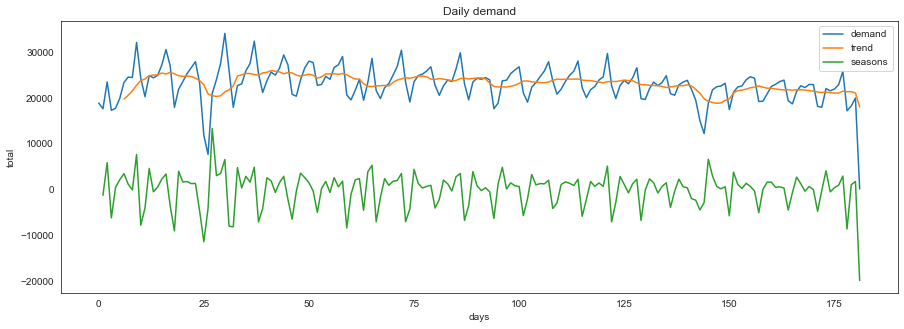

In [664]:
plt.figure(figsize=(15, 5))

plt.title('Daily demand')

demand_data.total.plot(label='demand');

demand_data.total.rolling(7).mean().plot(label='trend')

demand_data.total.diff().plot(label='seasons');

plt.ylabel('total');
plt.xlabel('days');
plt.legend();

## Autocorrelation

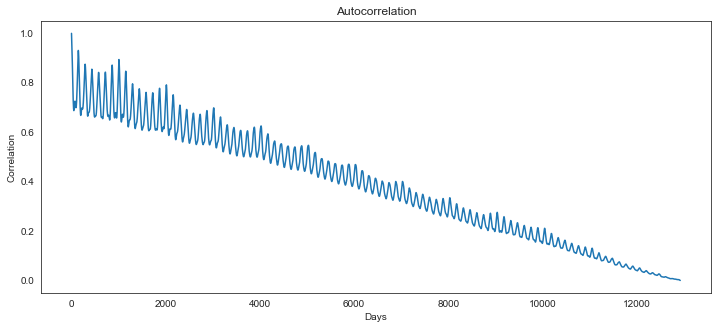

In [421]:
auto_corr = np.correlate(train_data.total, train_data.total, mode='full')
auto_corr = auto_corr[auto_corr.shape[0] // 2:]
auto_corr = auto_corr / auto_corr.max()

plt.figure(figsize=(12, 5))
plt.title('Autocorrelation')
plt.plot(auto_corr)
plt.xlabel('Days');
plt.ylabel('Correlation');

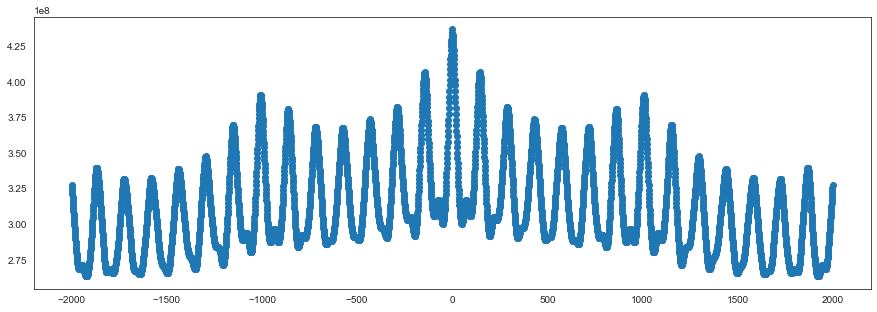

In [427]:
plt.figure(figsize=(15, 5))
plt.acorr(train_data.total.astype(float),
          usevlines=False,
          normed=False,
          maxlags=2000,
          lw=1);

## Seasonal plot

In [444]:
plt.figure(figsize=(15, 7))

time_data = train_data.copy()
groups = time_data.groupby(time_data.datetime.dt.date)

# time_data['month'] = time_data.datetime.dt.month
# time_data['day_of_month'] = time_data.datetime.dt.day

# plt.title('Seasonal plot')

# palette = sns.color_palette('hls', time_data.month.nunique())
# sns.lineplot(x='day_of_month',
#              y='total',
#              data=time_data,
#              estimator='mean',
#              ci=95,
#              hue='month',
#              palette=palette);

,total
datetime,
2015-01-01,18075
2015-01-02,17176
2015-01-03,22809
2015-01-04,16538
2015-01-05,17235
...,...
2015-03-27,25246
2015-03-28,28826
2015-03-29,22129


<Figure size 1080x504 with 0 Axes>

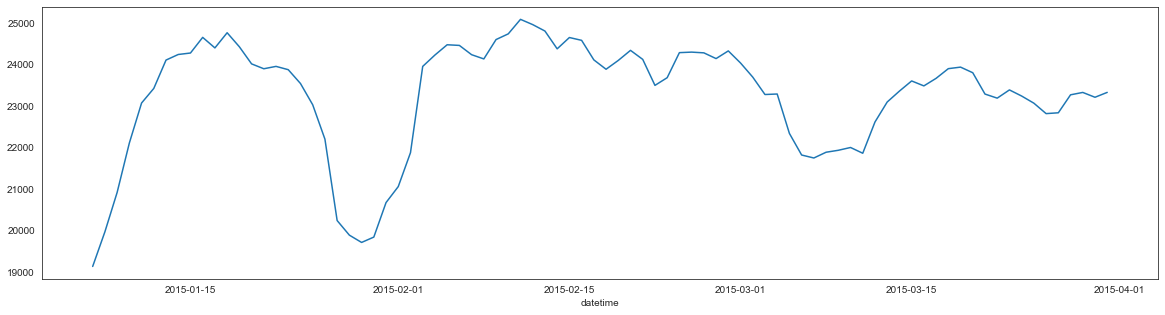

In [437]:
plt.figure(figsize=(20, 5))

time_data.groupby(time_data.datetime.dt.date).total.sum().rolling(7).mean().plot();

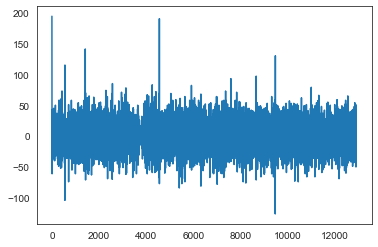

In [441]:
time_data.total.diff().plot();

In [440]:
time_data.total

0         44
1        238
2        302
3        316
4        336
        ... 
12921    164
12922    201
12923    192
12924    180
12925    168
Name: total, Length: 12926, dtype: int64